In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# 1. 加载GPP数据
print("正在加载GPP数据...")
store_gpp = 'gs://leap-persistent-ro/data-library/feedstocks/metaflux_feedstock/meatflux_monthly.zarr'
ds = xr.open_dataset(store_gpp, engine='zarr', chunks={})

# 2. 加载LAI数据
print("正在加载LAI数据...")
store_lai = 'https://nyu1.osn.mghpcc.org/leap-pangeo-pipeline/MODIS_LAI/MODIS_LAI.zarr'
LAI = xr.open_dataset(store_lai, engine='zarr', chunks={})

正在加载GPP数据...
正在加载LAI数据...


In [3]:
lat_ak = 65.0
lon_ak = -150.0
print(f"研究地点: ({lat_ak}°N, {lon_ak}°W)")

# 4. 提取GPP和RECO数据
print("提取碳通量数据...")
gpp_point = ds['GPP'].sel(latitude=lat_ak, longitude=lon_ak, method='nearest')
reco_point = ds['RECO'].sel(latitude=lat_ak, longitude=lon_ak, method='nearest')

研究地点: (65.0°N, -150.0°W)
提取碳通量数据...


In [6]:
nee_point = reco_point - gpp_point

print(f"GPP格点: ({gpp_point.latitude.values}, {gpp_point.longitude.values})")
print(f"GPP时间范围: {gpp_point.time.min().values} 到 {gpp_point.time.max().values}")


GPP格点: (65.0, -150.0)
GPP时间范围: 2001-01-01T00:00:00.000000000 到 2021-12-01T00:00:00.000000000


In [7]:
print("提取LAI数据...")
lai_point = LAI['lai'].sel(lat=lat_ak, lon=lon_ak, method='nearest')
print(f"LAI格点: ({lai_point.lat.values}, {lai_point.lon.values})")
print(f"LAI时间范围: {lai_point.time.min().values} 到 {lai_point.time.max().values}")

提取LAI数据...
LAI格点: (65.0250015258789, -149.97500610351562)
LAI时间范围: 2002-01-01T00:00:00.000000000 到 2020-12-26T00:00:00.000000000


In [8]:
# 6. 时间对齐 (2002-2020)
print("时间对齐...")
common_time = slice('2002-01-01', '2020-12-31')

lai_aligned = lai_point.sel(time=common_time).compute()
gpp_aligned = gpp_point.sel(time=common_time).compute()
nee_aligned = nee_point.sel(time=common_time).compute()

print(f"对齐后数据点数: LAI={len(lai_aligned)}, NEE={len(nee_aligned)}")


时间对齐...
对齐后数据点数: LAI=874, NEE=228


绘制碳通量图...


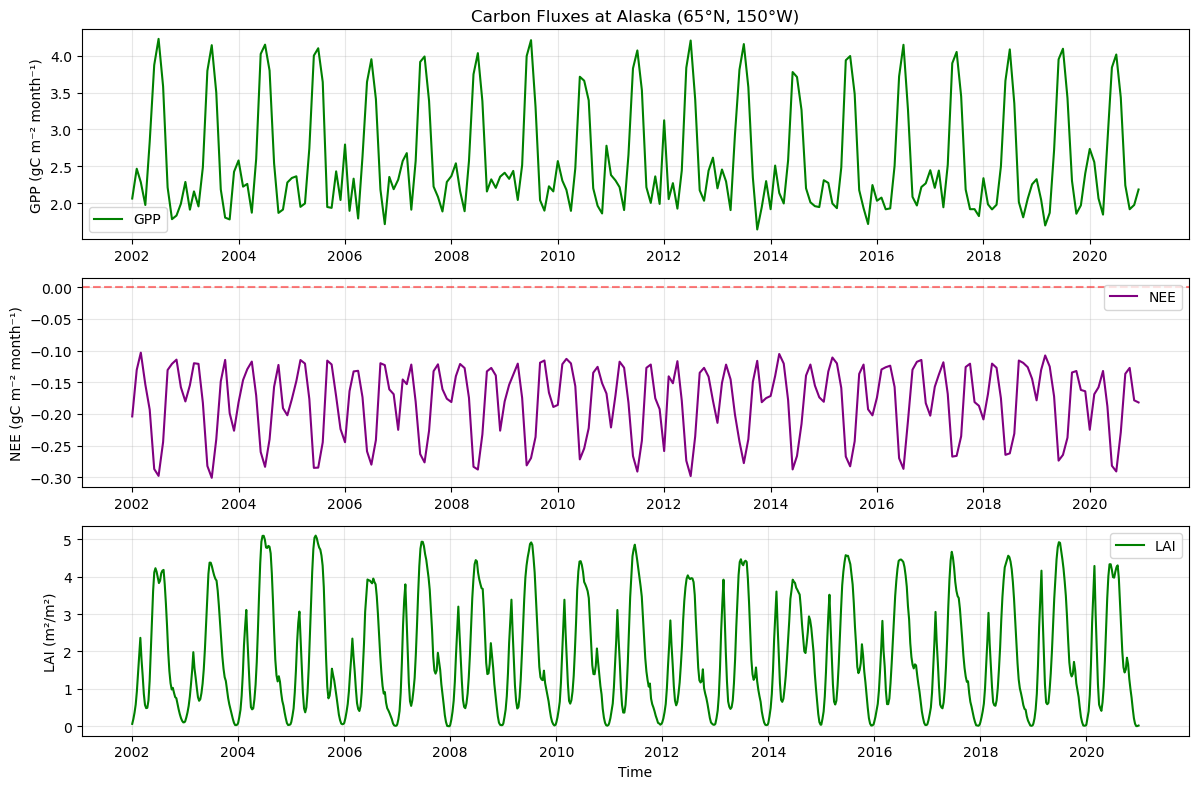

In [9]:
# 7. 绘制碳通量时间序列
print("绘制碳通量图...")
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(gpp_aligned.time, gpp_aligned.values, 'g-', label='GPP', linewidth=1.5)
plt.ylabel('GPP (gC m⁻² month⁻¹)')
plt.title('Carbon Fluxes at Alaska (65°N, 150°W)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(nee_aligned.time, nee_aligned.values, 'purple', label='NEE', linewidth=1.5)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.ylabel('NEE (gC m⁻² month⁻¹)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(lai_aligned.time, lai_aligned.values, 'green', label='LAI', linewidth=1.5)
plt.ylabel('LAI (m²/m²)')
plt.xlabel('Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
print(f"LAI数据长度: {len(lai_aligned)}")
print(f"NEE数据长度: {len(nee_aligned)}")

LAI数据长度: 874
NEE数据长度: 228


In [12]:
print("将LAI数据聚合为月度数据...")
lai_monthly = lai_aligned.resample(time='1M').mean()


将LAI数据聚合为月度数据...


/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


时间对齐...
对齐后数据点数: LAI=228, NEE=228


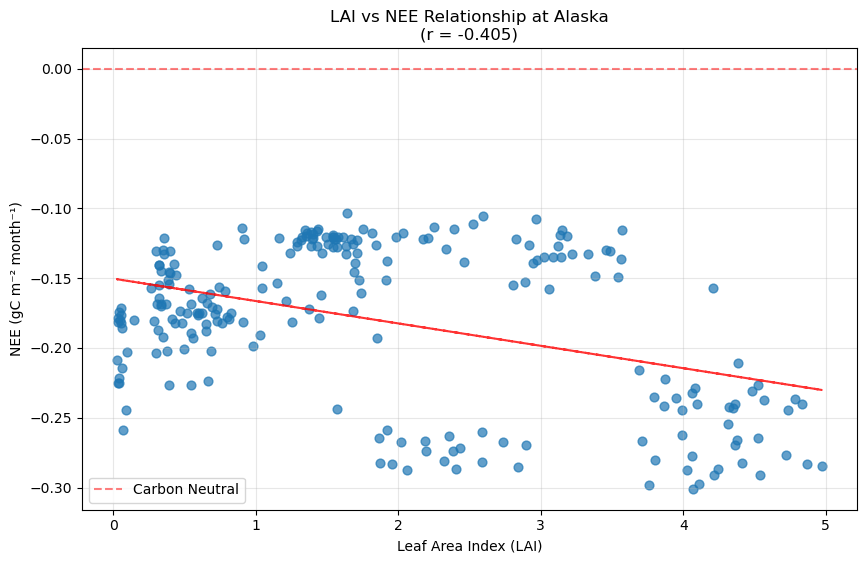


=== 统计信息 ===
LAI 范围: 0.028 - 4.971
NEE 范围: -0.301 - -0.103 gC m⁻² month⁻¹
NEE 平均值: -0.180 gC m⁻² month⁻¹
LAI-NEE 相关系数: -0.405
✅ 该生态系统总体为碳汇

=== 处理完成 ===


In [15]:
print("时间对齐...")
lai_final = lai_monthly.sel(time=nee_aligned.time, method='nearest')

print(f"对齐后数据点数: LAI={len(lai_final)}, NEE={len(nee_aligned)}")

# 计算相关性
correlation = np.corrcoef(lai_final.values, nee_aligned.values)[0, 1]

plt.figure(figsize=(10, 6))
plt.scatter(lai_final.values, nee_aligned.values, alpha=0.7, s=40)
plt.xlabel('Leaf Area Index (LAI)')
plt.ylabel('NEE (gC m⁻² month⁻¹)')
plt.title(f'LAI vs NEE Relationship at Alaska\n(r = {correlation:.3f})')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Carbon Neutral')
# 添加趋势线
z = np.polyfit(lai_final.values, nee_aligned.values, 1)
p = np.poly1d(z)
plt.plot(lai_final.values, p(lai_final.values), "r--", alpha=0.8)

plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 9. 打印统计信息（使用对齐后的数据）
print("\n=== 统计信息 ===")
print(f"LAI 范围: {lai_final.min().values:.3f} - {lai_final.max().values:.3f}")
print(f"NEE 范围: {nee_aligned.min().values:.3f} - {nee_aligned.max().values:.3f} gC m⁻² month⁻¹")
print(f"NEE 平均值: {nee_aligned.mean().values:.3f} gC m⁻² month⁻¹")
print(f"LAI-NEE 相关系数: {correlation:.3f}")

if nee_aligned.mean().values < 0:
    print("✅ 该生态系统总体为碳汇")
else:
    print("⚠️ 该生态系统总体为碳源")

print("\n=== 处理完成 ===")

=== NEE数据详细检查 ===
NEE标准差: 0.056
NEE中位数: -0.170


/tmp/ipykernel_211/861638104.py:20: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_211/861638104.py:20: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_211/861638104.py:20: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_211/861638104.py:20: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_211/861638104.py:20: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_211/861638104.py:20: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_211/861638104.py:20: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from

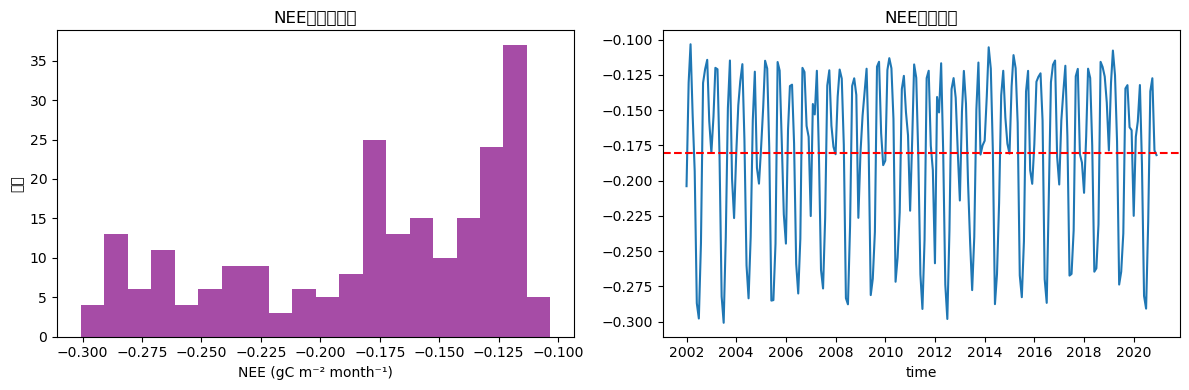

NEE唯一值数量: 228


In [16]:
# 检查NEE数据的真实分布
print("=== NEE数据详细检查 ===")
print(f"NEE标准差: {nee_aligned.std().values:.3f}")
print(f"NEE中位数: {nee_aligned.median().values:.3f}")

# 绘制NEE的直方图
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(nee_aligned.values, bins=20, alpha=0.7, color='purple')
plt.xlabel('NEE (gC m⁻² month⁻¹)')
plt.ylabel('频率')
plt.title('NEE分布直方图')

plt.subplot(1, 2, 2)
nee_aligned.plot()
plt.title('NEE时间序列')
plt.axhline(y=nee_aligned.mean().values, color='red', linestyle='--', label=f'均值: {nee_aligned.mean().values:.3f}')

plt.tight_layout()
plt.show()

# 检查是否有常数值
unique_nee = np.unique(nee_aligned.values)
print(f"NEE唯一值数量: {len(unique_nee)}")
if len(unique_nee) < 10:
    print(f"NEE唯一值: {unique_nee}")